In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import decode_image
from imageio.v2 import imread
from PIL import Image
import json
import requests as r
import os
import numpy as np
from torchvision.transforms import transforms



class PillDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.img_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = (self.img_paths.iloc[idx])
        image = Image.open(image_path)
        label = self.labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    


In [2]:
def getNormalizeTransform(x):
    images = np.stack(x.map(Image.open))
    mean = np.mean(images, axis=(0,1,2))
    std = np.std(images, axis=(0,1,2))
    return transforms.Normalize(mean, std)
    

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def zeroPadFront(x, desiredLength):
    x = str(x)
    while len(x) < desiredLength:
        x = '0' + x
    return x

all_labels = pd.read_csv("./datasets/ePillID_data/all_labels.csv")
codes = all_labels.apply(lambda x: zeroPadFront(x['label_code_id'], 4) + '-' + zeroPadFront(x['prod_code_id'], 4), axis=1)
all_labels['NDC'] = codes

numeric_labels = all_labels['NDC'].map(lambda x: codes.index[codes == x][0])
image_paths = all_labels['image_path'].map(lambda x: './datasets/ePillID_data/classification_data/' + x)
segmented_mask = all_labels['image_path'].str.startswith('segmented_nih_pills_224')

# epillid = PillDataset(image_paths[segmented_mask], numeric_labels[segmented_mask])

segmented_image_paths = image_paths[segmented_mask]
segmented_numeric_labels = numeric_labels[segmented_mask]

x_train, x_test, y_train, y_test = train_test_split(segmented_image_paths, segmented_numeric_labels, test_size=.2, random_state=42)

In [4]:
train_transform = transforms.Compose([transforms.ToTensor(),getNormalizeTransform(x_train)])
train_data = PillDataset(x_train, y_train, train_transform)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

In [5]:
test_transform = transforms.Compose([transforms.ToTensor(),getNormalizeTransform(x_test)])
test_data = PillDataset(x_test, y_test, test_transform)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)

#peel off last layer
model.fc = torch.nn.Identity() 


In [7]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


encodings = []
for x,y in test_dataloader:
    with torch.no_grad():
        encodings.extend(model(x))



In [10]:
from sklearn.decomposition import PCA

pca = PCA(2)
reduced_encodings = pca.fit_transform(encodings)

/var/folders/sl/ml3mpv252c199n1s9b4d2y3r0000gq/T/ipykernel_86259/3390026215.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_encodings[:, 0], reduced_encodings[:, 1], c='blue', s=50, cmap='viridis')


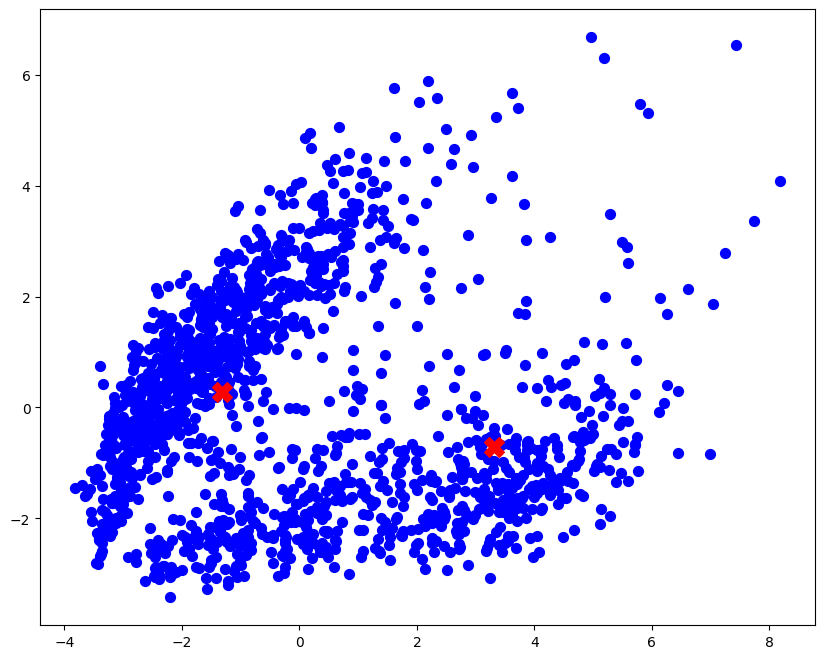

In [16]:
from sklearn.cluster import KMeans

n = 2
kmeans = KMeans(n_clusters=n, random_state=0)
kmeans.fit(reduced_encodings)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_encodings[:, 0], reduced_encodings[:, 1], c='blue', s=50, cmap='viridis')
center = kmeans.cluster_centers_
plt.scatter(center[:, 0], center[:, 1], c='red', s=200, marker='X', label='Centroids')

/var/folders/sl/ml3mpv252c199n1s9b4d2y3r0000gq/T/ipykernel_86259/2521284289.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_encodings[:, 0], reduced_encodings[:, 1], c='blue', s=50, cmap='viridis')


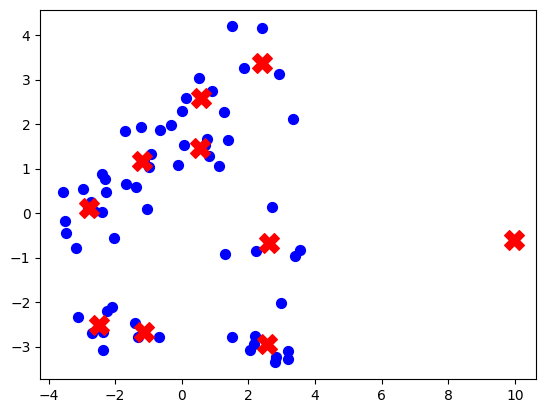

/var/folders/sl/ml3mpv252c199n1s9b4d2y3r0000gq/T/ipykernel_86259/2521284289.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_encodings[:, 0], reduced_encodings[:, 1], c='blue', s=50, cmap='viridis')


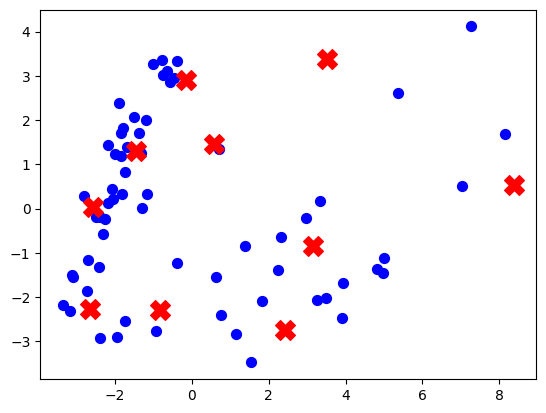

/var/folders/sl/ml3mpv252c199n1s9b4d2y3r0000gq/T/ipykernel_86259/2521284289.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_encodings[:, 0], reduced_encodings[:, 1], c='blue', s=50, cmap='viridis')


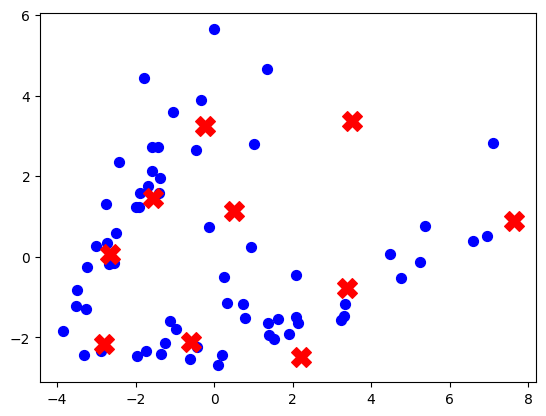

KeyboardInterrupt: 

In [24]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA



pca = PCA(2)

n = 10
kmeans = MiniBatchKMeans(n_clusters=n, random_state=0)

plt.ion()
for x,y in train_dataloader:
    with torch.no_grad():
        encodings = model(x)
    reduced_encodings = pca.fit_transform(encodings)
    kmeans.partial_fit(reduced_encodings)
    plt.scatter(reduced_encodings[:, 0], reduced_encodings[:, 1], c='blue', s=50, cmap='viridis')
    center = kmeans.cluster_centers_
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.pause(0.5)

plt.show()

